In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import FuncFormatter
# from adjustText import adjust_text

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显正负号

# plt.style.use('ggplot') # 重启IDE即可复原

#**********************************************************************
# jupyter notebook 图片显示模糊的解决办法
# 多加一行配置，就能够让 Matplotlib 在 Jupyter Notebook 上面输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # 指定了输出的格式是svg
#**********************************************************************

# 画图坐标轴数字显示为百分比格式
def to_percent(value, position):
    return '{:.2%}'.format(value)  # 显示2位百分数

In [2]:
from WindPy import w

w.start() # 默认命令超时时间为120秒，如需设置超时时间可以加入waitTime参数，例如waitTime=60,即设置命令超时时间为60秒  

w.isconnected() # 判断WindPy是否已经登录成功

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


True

In [3]:
# Bo: 注意，该记事本代码是基于"REITs_Index_WindPy"的仓库代码，用其生成好的指数数据，读取相关的EXCEL数据，并重新绘制了一些报告图表。

# 报告的日期区间
start_date = "2021-06-21"  # 起始日
end_date = "2023-08-31"  # 截止日


# 从之前生成的指数EXCEL中提取出指数数据。
path = r'D:\Work\DailyReport\REITs_Index_WindPy'
file = 'REITs_Index_Report_2023-08-31.xlsx' 


# 获取全部REITS的代码
reits_list = w.wset("sectorconstituent", "sectorid=1000041324000000", usedf=True)[1]['wind_code'].to_list()
reits_list

['180101.SZ',
 '180102.SZ',
 '180103.SZ',
 '180201.SZ',
 '180202.SZ',
 '180301.SZ',
 '180401.SZ',
 '180501.SZ',
 '180801.SZ',
 '508000.SH',
 '508001.SH',
 '508006.SH',
 '508008.SH',
 '508009.SH',
 '508018.SH',
 '508019.SH',
 '508021.SH',
 '508027.SH',
 '508028.SH',
 '508056.SH',
 '508058.SH',
 '508066.SH',
 '508068.SH',
 '508077.SH',
 '508088.SH',
 '508096.SH',
 '508098.SH',
 '508099.SH']

In [4]:

# 从某个SHEET提取对应的数据。
# 第1个参数是sheet名，后2个是列重命名
def GetData(sheetName, reName1, reName2):
    
    df = pd.read_excel(path + '\\' + file,sheet_name=sheetName)
    df.head()

    # 将第一列的日期设为index，方便后续与WIND返回的数据进行合并。
    df.index = df.iloc[:,0]
    df.index.name = "" # 去掉默认的名字“Unnamed: 0”
    df = df[["价格指数","总回报指数"]]  # 只要后2列

    # 列重命名
    df = df.rename(columns={"价格指数": reName1,"总回报指数": reName2})

    return df



# 合并提取的3个表

df_tmp = pd.merge(

                pd.merge(
                    # 1、取总指数，并重命名
                    GetData("C-REITs指数","德邦C-REITs价格指数","德邦C-REITs总回报指数"),
                    # 2、取产权指数，并重命名
                    GetData("产权类REITs指数","产权类REITs价格指数","产权类REITs总回报指数"),

                    left_index=True,right_index=True
                    ),

                # 3、取经营类指数，并重命名
                GetData("经营类REITs指数","经营类REITs价格指数","经营类REITs总回报指数"),

                                left_index=True,right_index=True
                            )



df_tmp


,德邦C-REITs价格指数,德邦C-REITs总回报指数,产权类REITs价格指数,产权类REITs总回报指数,经营类REITs价格指数,经营类REITs总回报指数
,,,,,,
2021-06-21,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-06-22,98.281168,98.281168,97.930679,97.930679,98.733381,98.733381
2021-06-23,97.684942,97.684942,97.219802,97.219802,98.284871,98.284871
2021-06-24,97.431284,97.431284,97.145270,97.145270,97.800733,97.800733
2021-06-25,97.614799,97.614799,97.221479,97.221479,98.122341,98.122341
...,...,...,...,...,...,...
2023-08-25,95.508653,104.450366,108.338216,114.358098,80.812012,92.644105
2023-08-28,95.645589,104.600122,108.446575,114.472478,80.974563,92.830456
2023-08-29,95.305907,104.374150,108.041739,114.045147,80.706558,92.824251


In [5]:
# 获取中证REITs及股债指数：注意选择考虑分红再投资的对应的回报指数，而非价格指数。

# 中证REITs(收盘)全收益指数：932006CNY01.CSI 
# 沪深300全收益指数：H00300.CSI
# 中债-新综合财富(总值)指数：CBA00101.CS
df = w.wsd(["932006CNY01.CSI","H00300.CSI","CBA00101.CS"], "close", start_date, end_date, usedf=True)[1]

# 合并中证REITs及股债指数
df_tmp = pd.merge(
                # 重命名列
                df.rename(columns={"932006CNY01.CSI": "中证REITs全收益指数","H00300.CSI": "沪深300全收益指数",
                                  "CBA00101.CS": "中债-新综合财富(总值)指数"}),

                df_tmp,

                left_index=True,right_index=True
                )


# 获取各个REIT的每日成交额，WIND函数为amt，单元为元

df = w.wsd(reits_list, "amt", start_date, end_date, usedf=True)[1]


# 合并每日成交额

df_tmp = pd.merge(

                (df.sum(axis=1)/10000).to_frame("总成交额(万元)"), # 当日全部成交额加总，单位转万元

                df_tmp,

                left_index=True,right_index=True
                )



df_tmp

,总成交额(万元),中证REITs全收益指数,沪深300全收益指数,中债-新综合财富(总值)指数,德邦C-REITs价格指数,德邦C-REITs总回报指数,产权类REITs价格指数,产权类REITs总回报指数,经营类REITs价格指数,经营类REITs总回报指数
,,,,,,,,,,
2021-06-21,185962.5384,NaN,6668.0974,206.0171,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-06-22,50779.5903,NaN,6710.1453,206.0465,98.281168,98.281168,97.930679,97.930679,98.733381,98.733381
2021-06-23,24007.3136,NaN,6743.9179,206.1181,97.684942,97.684942,97.219802,97.219802,98.284871,98.284871
2021-06-24,15960.7040,NaN,6756.9170,206.1921,97.431284,97.431284,97.145270,97.145270,97.800733,97.800733
2021-06-25,12733.1476,NaN,6871.8496,206.2454,97.614799,97.614799,97.221479,97.221479,98.122341,98.122341
...,...,...,...,...,...,...,...,...,...,...
2023-08-25,28991.7244,969.9883,5144.1057,227.6519,95.508653,104.450366,108.338216,114.358098,80.812012,92.644105
2023-08-28,35275.4656,971.6626,5205.2753,227.5501,95.645589,104.600122,108.446575,114.472478,80.974563,92.830456
2023-08-29,31092.2795,969.1618,5257.4001,227.4952,95.305907,104.374150,108.041739,114.045147,80.706558,92.824251


In [6]:
# 将其他对比指数，进行标准化调整！起始调整为100

# 1、中证基日为2021年9月30日，基点为1000。直接将其除以10
# 2、股债指数将其标准化为100,除以首期值(2021年6月21日)


df_tmp.loc[:,"中证REITs全收益指数"] = df_tmp["中证REITs全收益指数"] / 10

df_tmp.loc[:,"沪深300全收益指数"] = df_tmp["沪深300全收益指数"] / df_tmp["沪深300全收益指数"].iloc[0] * 100
df_tmp.loc[:,"中债-新综合财富(总值)指数"] = df_tmp["中债-新综合财富(总值)指数"] / df_tmp["中债-新综合财富(总值)指数"].iloc[0] * 100

df_tmp

,总成交额(万元),中证REITs全收益指数,沪深300全收益指数,中债-新综合财富(总值)指数,德邦C-REITs价格指数,德邦C-REITs总回报指数,产权类REITs价格指数,产权类REITs总回报指数,经营类REITs价格指数,经营类REITs总回报指数
,,,,,,,,,,
2021-06-21,185962.5384,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-06-22,50779.5903,NaN,100.630583,100.014271,98.281168,98.281168,97.930679,97.930679,98.733381,98.733381
2021-06-23,24007.3136,NaN,101.137063,100.049025,97.684942,97.684942,97.219802,97.219802,98.284871,98.284871
2021-06-24,15960.7040,NaN,101.332008,100.084944,97.431284,97.431284,97.145270,97.145270,97.800733,97.800733
2021-06-25,12733.1476,NaN,103.055627,100.110816,97.614799,97.614799,97.221479,97.221479,98.122341,98.122341
...,...,...,...,...,...,...,...,...,...,...
2023-08-25,28991.7244,96.99883,77.145029,110.501458,95.508653,104.450366,108.338216,114.358098,80.812012,92.644105
2023-08-28,35275.4656,97.16626,78.062377,110.452045,95.645589,104.600122,108.446575,114.472478,80.974563,92.830456
2023-08-29,31092.2795,96.91618,78.844081,110.425397,95.305907,104.374150,108.041739,114.045147,80.706558,92.824251


In [7]:
# # pandas面积图: plot.area()
# df_tmp.iloc[:,0].plot.area()

# df_tmp.iloc[:,1:].plot()

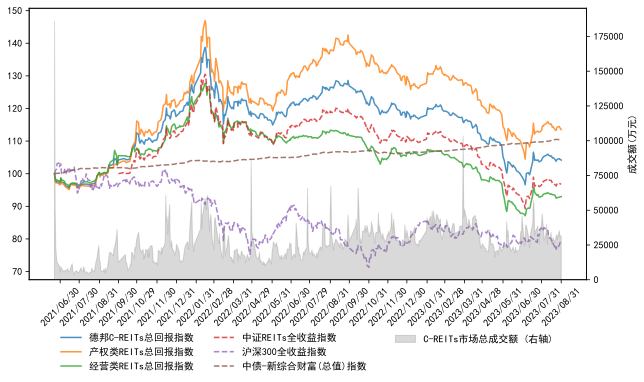

In [8]:
# Python绘制组合图(折线图和面积图，主次坐标轴，双y轴)

#取出作图的数据
x = df_tmp.index
y1 =df_tmp.iloc[:,1]
y2 =df_tmp.iloc[:,2]
y3 =df_tmp.iloc[:,3]
y4 =df_tmp.iloc[:,5]
y5 =df_tmp.iloc[:,7]
y6 =df_tmp.iloc[:,9]

y_amt = df_tmp.iloc[:,0]

# fig, ax1 = plt.subplots()
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
# 标题
# ax1.set_title("C-REITs市场走势图",fontsize='15')
# plt.title("C-REITs市场走势图",fontsize='15')  # 方法2：这样也行

# 画折线图
ax1.plot(x, y4, alpha = .8, label = y4.name)
ax1.plot(x, y5, alpha = .8, label = y5.name)
ax1.plot(x, y6, alpha = .8, label = y6.name)
ax1.plot(x, y1, alpha = .8, label = y1.name, linestyle= '--')  # 对比指数均采用虚线
ax1.plot(x, y2, alpha = .8, label = y2.name, linestyle= '--')  # 对比指数均采用虚线
ax1.plot(x, y3, alpha = .8, label = y3.name, linestyle= '--')  # 对比指数均采用虚线

# 图例
# ax1.legend(("价格指数",), loc = [0.2, -0.155])
# ax1.legend(("价格指数","总回报指数"), loc = [0.2, -0.155])
ax1.legend(loc = [0.05, -0.35], ncol=2, frameon=False)
# ax1.legend(loc = "upper left")

# 设置轴标题
# ax1.set_ylabel('价格指数',fontsize='12')
# plt.ylabel('价格指数',fontsize='12') # 方法2：这样也行
# 设置轴区间
# ax1.set_ylim(50, 150)
# plt.ylim(50, 150) # 方法2：这样也行


#############################################################
ax2 = ax1.twinx() #组合图必须加这个!!!!!
# twinx()函数表示共享x轴
# twiny()表示共享y轴
# 共享表示的就是x轴使用同一刻度线
#############################################################\

#画面积图
# plt.fill_between(x, y_amt,alpha=.3,color='gray')
plt.stackplot(x, y_amt,alpha=.3,color='gray') # 面积图方法2：这样也行

# 设置轴和图例
ax2.legend(("C-REITs市场总成交额 (右轴)",), loc = [0.65, -0.25], frameon=False)
ax2.set_ylabel('成交额(万元)',fontsize='10')


# 设置X轴格式
#****************************************************************************************************
# 注意：必须要在组合图ax1和ax2都画完之后统一设置，如果在ax1后面设置X轴，会被后面ax2覆盖导致没有效果！
# 1、日期格式化显示
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

# 2、坐标轴日期间隔，倾斜度
my_x_ticks = pd.date_range(start_date, end_date, freq='BM') # BM月末，MS月初，季度末：Q-JAN, Q-FEB
ax1.set_xticks(my_x_ticks)
ax1.tick_params(axis='x',rotation=45)  # 默认 axis='both'表示两条轴同时设置。此外，这里用ax2貌似没有效果，只能用ax1

# 注意：这里用下面的plt去设置坐标轴貌似会报错，只能用上面ax去设置
# plt.xticks(my_x_ticks) 
# plt.xticks(rotation=45) # X轴倾斜45度
#****************************************************************************************************

# 保存成png的格式，dpi取500，300貌似都行，越高的分辨率越高，对应的文件大小越大
plt.savefig("C-REITs市场走势图.png", dpi=500, bbox_inches='tight')  

plt.show()

In [9]:

# 由所有指数的点位数据，计算月度或者年度的涨跌幅
def cal_return_from_prices(freq):

    # 每日涨跌幅
    df = (df_tmp-df_tmp.shift(1))/ df_tmp.shift(1)

    # 简单收益率转换成对数收益率：方便后面相加
    df = df.apply(lambda x: np.log(1 + x))

    # 按月或者年分组计算区间内的收益率，对数收益率可以直接相加!
    df = df.groupby(df.index.to_period(freq)).sum()  # 按月M；按季度是q；按年是a

    # 对数收益率转简单收益率，即月涨跌幅
    # 1+简单收益率=收盘价/前个收盘价=exp(对数收益率)
    # 简单收益率=exp(对数收益率)-1
    df = df.apply(lambda x: np.exp(x) - 1)

    # 只保留这些列
    df = df.loc[:,["德邦C-REITs总回报指数","产权类REITs总回报指数","经营类REITs总回报指数","中证REITs全收益指数","沪深300全收益指数",
                    "中债-新综合财富(总值)指数"]]


    return df

In [10]:
# Python中的日期与字符串之间的转换：时间函数strftime与strptime对比
# https://zhuanlan.zhihu.com/p/387187779

# strftime： 将给定格式的日期时间对象转换为字符串。日期时间对象=>字符串，控制输出格式
# strptime：将字符串解析为给定格式的日期时间对象。字符串=>日期时间对象，解析字符串


# 字符串转日期
date_object = datetime.strptime(end_date, "%Y-%m-%d")
date_object

# 日期转字符串
print(date_object.strftime("%Y-%m"))  # 只取到月，比如"2023-08"
print(date_object.strftime("%Y"))  # 只取到年，比如"2023"

# cal_return_from_prices("M")

2023-08
2023


In [11]:
df_chart = pd.merge(

                    # 生成月份收益率，并取当月的收益率
                    cal_return_from_prices("M").loc[date_object.strftime("%Y-%m")].to_frame("本月"),
                    # 其中cal_return_from_prices("M")返回的是以每月为index的dataframe

                    # 生成年份收益率，并取当月的收益率
                    cal_return_from_prices("a").loc[date_object.strftime("%Y")].to_frame("今年以来"),
                    # 其中cal_return_from_prices("a")返回的是以每年为index的dataframe

                    left_index=True,right_index=True
    
)

df_chart

,本月,今年以来
德邦C-REITs总回报指数,0.000489,-0.125335
产权类REITs总回报指数,0.001591,-0.125773
经营类REITs总回报指数,-0.000922,-0.125173
中证REITs全收益指数,0.002480,-0.131483
沪深300全收益指数,-0.060241,-0.005410
中债-新综合财富(总值)指数,0.006534,0.037188


In [12]:
df_chart.T


,德邦C-REITs总回报指数,产权类REITs总回报指数,经营类REITs总回报指数,中证REITs全收益指数,沪深300全收益指数,中债-新综合财富(总值)指数
本月,0.000489,0.001591,-0.000922,0.002480,-0.060241,0.006534
今年以来,-0.125335,-0.125773,-0.125173,-0.131483,-0.005410,0.037188


<AxesSubplot:>

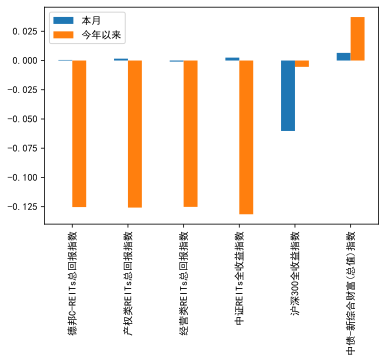

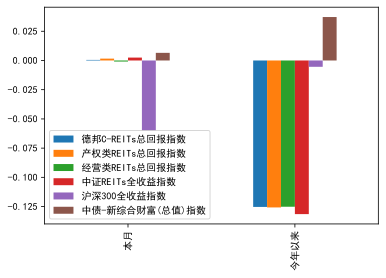

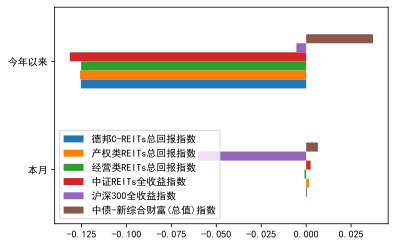

In [13]:
# 速画图像
df_chart.plot(kind='bar')
df_chart.T.plot(kind='bar')
df_chart.T.plot.barh()  # 转置后，使用barh貌似会是标签的显示顺序反过来，故暂时不采用！参考链接： https://www.cnpython.com/qa/43752

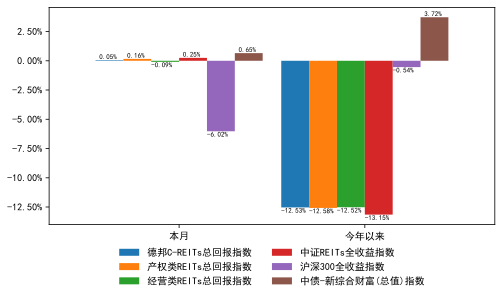

In [14]:

# 画图：月度及年度回报对比：大类指数

bar_chart = df_chart.T.plot.bar(figsize=(8,4),width=0.9)  # 这里df_chart.T转置了,index变成“今年以来”和“本月”
# 使用barh貌似会是标签的显示顺序反过来，故暂时不采用！参考链接： https://www.cnpython.com/qa/43752
# width决定了柱子的宽度，仅代表形状宽度而已，默认似乎为0.5
# 这里取bar_chart是为了后续调用bar_chart.patches，设置图像数据的标签

# 格式美化
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))  # y轴百分位格式
plt.xticks(rotation=0) # X轴水平，默认是90度垂直的
plt.legend(bbox_to_anchor=(0.5, -0.3), loc=8, borderaxespad=0,fontsize=10, ncol=2, frameon=False) # legend在图外正下方
# 添加数字标签
yRange= plt.ylim()[1]-plt.ylim()[0] # plt.ylim()返回图像y轴的上下界，结果是tuple；等价于plt.gca().get_ylim()
for rect in bar_chart.patches:
    if rect.get_height() > 0: # 柱状图的高度即为值，如果为正，当柱子很少(这里大概是6个)，柱子比较宽，适当调整了x位置让其居中
        plt.annotate(f"{rect.get_height():.2%}",(rect.get_x() + (0.02 if rect.get_width()>0.12 else 0),
                                                 rect.get_y()+rect.get_height()+yRange/200),fontsize=7) # yRange/200大概是0.001
    else: # 负的柱子，调整y位置，下面的值：-yRange/40是试出来的，先找了个合适的绝对值出来，然后观察与y轴范围的关系。
        plt.annotate(f"{rect.get_height():.2%}",(rect.get_x(),rect.get_y()+rect.get_height()-yRange/40),fontsize=7) # yRange/40

        
# 保存成png的格式，dpi取500，300貌似都行，越高的分辨率越高，对应的文件大小越大
plt.savefig("C-REITs月度及年度回报对比.png", dpi=1000, bbox_inches='tight')  

plt.show()

In [15]:

# REITs细分板块(项目类型)：FUND__REITSTYPE
# 基金简称：fund_info_name 基金场内简称：fund_exchangeshortname
df = w.wss(reits_list, "fund_info_name, fund_exchangeshortname, fund_reitsrproperty, fund__reitstype", usedf=True)[1]

df

,FUND_INFO_NAME,FUND_EXCHANGESHORTNAME,FUND_REITSRPROPERTY,FUND__REITSTYPE
180101.SZ,博时招商蛇口产业园REIT,博时蛇口产园REIT,产权类,园区基础设施
180102.SZ,华夏合肥高新产园REIT,华夏合肥高新REIT,产权类,园区基础设施
180103.SZ,华夏杭州和达高科产园REIT,华夏和达高科REIT,产权类,园区基础设施
180201.SZ,平安广州交投广河高速公路REIT,平安广州广河REIT,特许经营类,交通基础设施
180202.SZ,华夏越秀高速公路封闭式基础设施REIT,华夏越秀高速REIT,特许经营类,交通基础设施
180301.SZ,红土创新盐田港仓储物流REIT,红土创新盐田港REIT,产权类,仓储物流
180401.SZ,鹏华深圳能源REIT,鹏华深圳能源REIT,产权类,能源基础设施
180501.SZ,红土创新深圳人才安居REIT,红土创新深圳安居REIT,产权类,保障性租赁住房
180801.SZ,中航首钢生物质REIT,中航首钢绿能REIT,特许经营类,生态环保
508000.SH,华安张江产业园REIT,张江REIT,产权类,园区基础设施


In [16]:

# 绘制各REITs细分板块的月度/年度的涨跌幅

# reitsType：细分板块名称
# 对比的指数包含沪深300全收益指数，以及一个可选的股票板块指数(如有)：代码及图中显示的名称
# 可变参数index2Compare: 长度可变，每个元素均为tuple，即(代码, 自定义名称)
# 案例：(Python中函数的各种类型参数详解)  https://blog.csdn.net/oJinGangZuan/article/details/127204208

def plot_return_comparision_per_reits_type(reitsType, *index2Compare):

    # 获取对应REITs细分版块的全部代码
    df = w.wss(reits_list, "fund_reitsrproperty, fund__reitstype", usedf=True)[1]
    codes_list = df[df["fund__reitstype".upper()]==reitsType].index.to_list()
    
    # 获取细分板块对应的流通市值(取当月月末值)，计算权重。
    # 获取日截面数据函数WSS。WSS支持取多品种多指标某个时间点的截面数据。可以指定日期(可选，不填则默认最新数据)，参数tradeDate
    df = w.wss(codes_list, "val_mvc", f"tradeDate={end_date}", usedf=True)[1] # REITs流通市值(val_mvc)
    weights = df/df.sum()
    
#     print(weights)
#     print(len(weights))
    
    # 添加要对比的指数，N个可选指数(可变参数)，长度可变，每个元素均为tuple，格式为(代码, 自定义名称)
    for indexCode, indexName in index2Compare:
        codes_list = codes_list + [indexCode] # 列表合并操作
    # 添加沪深300全收益指数：H00300.CSI
    codes_list = codes_list + ["H00300.CSI"] # 沪深300放在最后面
                               
    # 获取每日涨跌幅
    df=w.wsd(codes_list, 
          "pct_chg", 
          start_date, end_date, "priceAdj=U", usedf=True)[1]  # "priceAdj=U"不起作用，实际用的复权

    # 重命名REITs列：代码=》简称。# 基金简称：fund_info_name 基金场内简称：fund_exchangeshortname
    df = df.rename(columns=w.wss(reits_list, "fund_exchangeshortname", # 基金场内简称：fund_exchangeshortname
                                 usedf=True)[1].to_dict()["fund_exchangeshortname".upper()])
    # 重命名可选的指数列
    for indexCode, indexName in index2Compare:
        df = df.rename(columns={indexCode: indexName})                      
    # 重命名沪深300
    df = df.rename(columns={"H00300.CSI": "沪深300"})

    # WIND涨跌幅(pct_chg)简单收益率转换成对数收益率，因为对数收益率方便直接相加！
    # 1+简单收益率=收盘价/前个收盘价=exp(对数收益率)
    # 对数收益率=Ln(1+简单收益率)
    df=df.apply( lambda x: np.log(1+x/100)) # WIND涨跌幅返回值需要除100

    # 将日期index转换object为日期类型，方便后续使用日期函数相关的操作
    df.index=pd.to_datetime(df.index,format='%Y-%m-%d') 

    
    # 计算月度和年度收益率
    
    # 方法一(有BUG)，直接使用WIND函数，月度涨跌幅pct_chg：传入参数Period=M，默认是D
    #*************************************************************************************
    # 注意：这里WIND计算首月涨跌幅时有BUG！！！非上市首月的涨跌幅则没问题。
    # pct_chg计算首月涨跌幅的分母似乎是上市首日的收盘价，而不是发行价格；而pct_chg默认的日涨跌幅序列，首日的涨跌幅分母是发行价，没问题。
    #*************************************************************************************
    # 方法二(推荐！)，基于日涨跌幅，手动分组，计算月涨跌幅！
    # Pandas按月份和年份分组（日期为datetime64[ns]），并汇总
    # https://www.cnpython.com/qa/1311357
    
    # 按月分组并求和(按月M；按季度是q；按年是a)
    # datetime支持to_period转换，因此我们可以按月对所有内容进行分组
    # 注意这里的日期刚好在index中，可以直接df.index.to_period('M')。否则如果日期是某一列中，则应该接一个dt比如df['date'].dt.to_period('M')
    df_month = df.groupby(df.index.to_period('M')).sum()  # 这里sum()会将NA当成0处理
    # 对数收益率转简单收益率，即月涨跌幅
    df_month = df_month.apply(lambda x: np.exp(x)-1)

    # 按年分组并求和(按月M；按季度是q；按年是a)
    df_year = df.groupby(df.index.to_period('a')).sum()  # 这里sum()会将NA当成0处理
    # 对数收益率转简单收益率，即月涨跌幅
    df_year = df_year.apply(lambda x: np.exp(x)-1)
    
     
    # 取当月和当月数据，并合并
    df_chart = pd.merge(

                    # 取当月的收益率
                    df_month.loc[date_object.strftime("%Y-%m")].to_frame("本月"),
                    # 取当年的收益率
                    df_year.loc[date_object.strftime("%Y")].to_frame("今年以来"),
        
                    left_index=True,right_index=True
    
    )

#     print(df_chart)
    
    
    # 根据之前计算的权重数据，计算细分板块REITs的本月和今年以来的整体表现。
    weight_sums = ((df_chart.iloc[:len(weights)].values) * (weights.values)).sum(axis=0)
    # len(weights)：只取前N行的REITs数据，.values转化为numpy方便运用广播机制，pandas的广播机制貌似不太好用
    # weights.values是一个1 x len(weights)的矩阵，列向量，会广播成2列，分别与“本月”列和“今年以来”列相除。

    # 方法一：直接插入一行。但是位置是在dataframe的最后一行。
    # new_row = {'本月': weight_sums[0], '今年以来': weight_sums[1]}
    # df_chart.loc["整体REITs表现", :] = new_row  # 新增一行
    
    # 方法二：concat插入新行，这样可以调整到首行
    df_chart = pd.concat([pd.DataFrame({'本月': weight_sums[0], '今年以来': weight_sums[1]},index=[reitsType + "类REITs整体"]),
                          df_chart])
    # concat(): 将多个Series或DataFrame连接到一起，默认为按行连接(axis参数默认为0)，结果的行数为被连接数据的行数之和。
    
    
    # 画图
    bar_chart = df_chart.T.plot.bar(figsize=(8,4),width=0.9)  # 这里df_chart.T转置了,index变成“今年以来”和“本月”
    # width决定了柱子的宽度，仅代表形状宽度而已，默认似乎为0.5
    # 格式美化
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))  # y轴百分位格式
    plt.xticks(rotation=0) # X轴水平，默认是90度垂直的
    plt.legend(bbox_to_anchor=(0.5, -0.35), loc=8, borderaxespad=0,fontsize=10, ncol=4, frameon=False) # legend在图外正下方
    # 添加数字标签：plt.annotate('text',(x,y))
    yRange= plt.ylim()[1]-plt.ylim()[0] # plt.ylim()返回图像y轴的上下界，结果是tuple；等价于plt.gca().get_ylim()
    for rect in bar_chart.patches:
        if rect.get_height() > 0: # 柱状图的高度即为值，如果为正，当柱子很少(这里大概是6个)，柱子比较宽，适当调整了x位置让其居中
            plt.annotate(f"{rect.get_height():.2%}",(rect.get_x() + (0.02 if rect.get_width()>0.12 else 0),
                                                     rect.get_y()+rect.get_height()+yRange/200),fontsize=7) # yRange/200大概是0.001
        else: # 负的柱子，调整y位置，下面的值：-yRange/40是试出来的，先找了个合适的绝对值出来，然后观察与y轴范围的关系。
            plt.annotate(f"{rect.get_height():.2%}",(rect.get_x(),rect.get_y()+rect.get_height()-yRange/40),fontsize=7) # yRange/40
    
    # 保存成png的格式，dpi取500，300貌似都行，越高的分辨率越高，对应的文件大小越大
    plt.savefig(f"{reitsType}月度及年度回报对比.png", dpi=1000, bbox_inches='tight')  
    plt.show()


    return df_chart

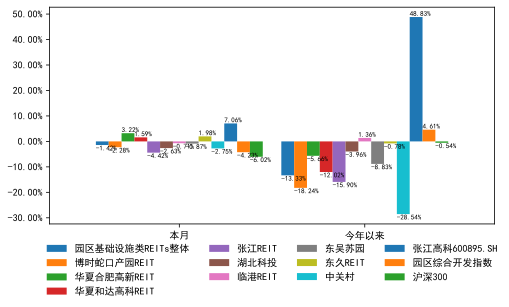

,本月,今年以来
园区基础设施类REITs整体,-0.014188,-0.133267
博时蛇口产园REIT,-0.022811,-0.182363
华夏合肥高新REIT,0.032221,-0.056563
华夏和达高科REIT,0.015889,-0.120159
张江REIT,-0.044179,-0.159018
湖北科投,-0.026265,-0.039619
临港REIT,-0.007073,0.013589
东吴苏园,-0.008651,-0.088347
东久REIT,0.019751,-0.007789
中关村,-0.027460,-0.285362


In [17]:
# 添加要对比的指数，N个可选指数(可变参数)，长度可变，每个元素均为tuple，格式为(代码, 自定义名称)
plot_return_comparision_per_reits_type("园区基础设施", ("600895.SH","张江高科600895.SH"),("CI005351.WI","园区综合开发指数"))

# 下面这种方法也可以，就是可变参数打包成一个list或tuple，但是最终传入的时候，必须也加个*，表示解包成元素，作为可变参数传入函数中！
# index_list = [("600895.SH","张江高科600895.SH"),("CI005351.WI","园区综合开发指数")]
# plot_return_comparision_per_reits_type("园区基础设施", *index_list)


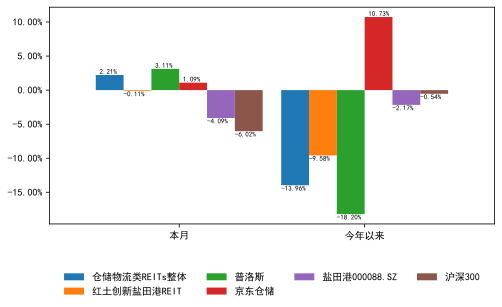

,本月,今年以来
仓储物流类REITs整体,0.022146,-0.139644
红土创新盐田港REIT,-0.001113,-0.095844
普洛斯,0.031146,-0.182006
京东仓储,0.010912,0.107285
盐田港000088.SZ,-0.040936,-0.021696
沪深300,-0.060241,-0.005410


In [18]:
plot_return_comparision_per_reits_type("仓储物流",("000088.SZ","盐田港000088.SZ"))

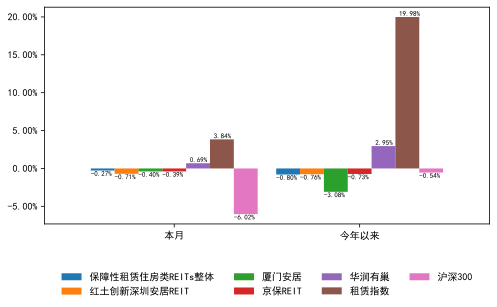

,本月,今年以来
保障性租赁住房类REITs整体,-0.002742,-0.008016
红土创新深圳安居REIT,-0.007087,-0.007562
厦门安居,-0.003954,-0.030848
京保REIT,-0.003931,-0.007293
华润有巢,0.006879,0.029531
租赁指数,0.038378,0.199849
沪深300,-0.060241,-0.005410


In [19]:
plot_return_comparision_per_reits_type("保障性租赁住房",("CI005526.WI","租赁指数"))

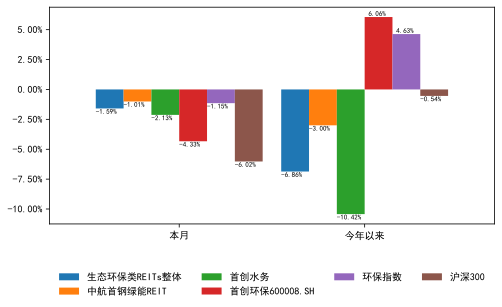

,本月,今年以来
生态环保类REITs整体,-0.015898,-0.068634
中航首钢绿能REIT,-0.010072,-0.029994
首创水务,-0.021266,-0.104237
首创环保600008.SH,-0.043333,0.060556
环保指数,-0.011464,0.046309
沪深300,-0.060241,-0.005410


In [20]:
plot_return_comparision_per_reits_type("生态环保",("600008.SH","首创环保600008.SH"),("886024.WI","环保指数"))

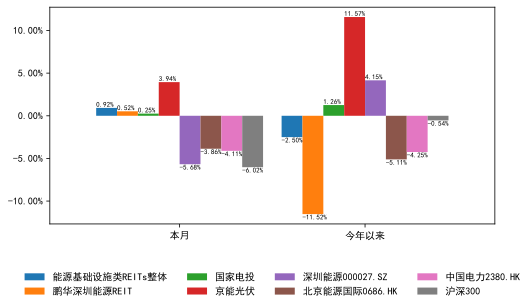

,本月,今年以来
能源基础设施类REITs整体,0.009209,-0.025010
鹏华深圳能源REIT,0.005236,-0.115234
国家电投,0.002526,0.012551
京能光伏,0.039429,0.115723
深圳能源000027.SZ,-0.056769,0.041545
北京能源国际0686.HK,-0.038647,-0.051115
中国电力2380.HK,-0.041096,-0.042461
沪深300,-0.060241,-0.005410


In [21]:
plot_return_comparision_per_reits_type("能源基础设施",("000027.SZ","深圳能源000027.SZ"),("0686.HK","北京能源国际0686.HK"),
                                      ("2380.HK","中国电力2380.HK"))

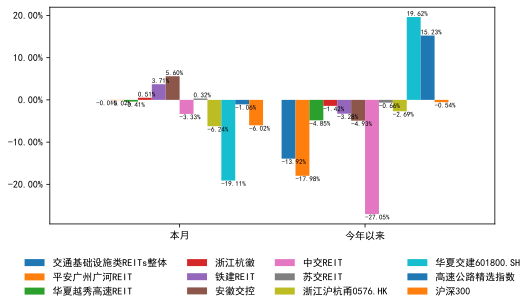

,本月,今年以来
交通基础设施类REITs整体,-0.000140,-0.139201
平安广州广河REIT,-0.000668,-0.179759
华夏越秀高速REIT,-0.004108,-0.048453
浙江杭徽,0.005093,-0.014190
铁建REIT,0.037090,-0.032785
安徽交控,0.055957,-0.049281
中交REIT,-0.033305,-0.270464
苏交REIT,0.003233,-0.006559
浙江沪杭甬0576.HK,-0.062400,-0.026923
华夏交建601800.SH,-0.191088,0.196167


In [22]:
plot_return_comparision_per_reits_type("交通基础设施",("0576.HK","浙江沪杭甬0576.HK"),("601800.SH","华夏交建601800.SH"),
                                      ("8841399.WI","高速公路精选指数"))

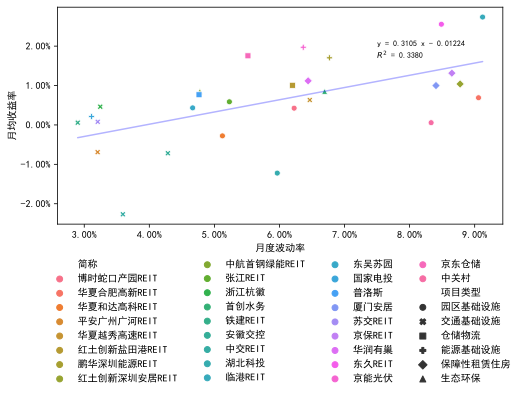

In [23]:
# REITs风险收益图

# 读取生成的数据
df = pd.read_excel(path + '\\' + file,sheet_name="REITs风险收益")

# 将读取的第1列设置为索引，空白列名，默认值是'Unnamed: 0'
df.set_index('Unnamed: 0', inplace=True)
df.index.name=""  # 去掉'Unnamed: 0'

# 获取细分类别字段，并合并
df = pd.merge(
                        df,
                        # REITs属性(产权/经营权): fund_reitsrproperty；REITs细分板块(项目类型)：FUND__REITSTYPE
                        w.wss(df.index.to_list(), "fund_reitsrproperty, fund__reitstype", 
                              usedf=True)[1].rename(columns={"fund__reitstype".upper(): "项目类型"}), # 顺便重名列名，方便后面
                        left_index=True,right_index=True

                    )

df


# 画图
plt.figure(figsize=(8, 4))

# 这里画图的代码可以进一步参考：REITs_chart_v20230204.ipynb
# 案例一：sns画类别散点气泡图：
# http://seaborn.pydata.org/generated/seaborn.scatterplot.html
# https://blog.csdn.net/qq_45913057/article/details/123366205
# 优点：方便简洁：legend清晰
sns.scatterplot(data=df, x='月度波动率',y='月均收益率', hue="简称", style="项目类型")

# 百分比格式
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
# the trendline    

# 添加趋势线并标注
x=df['月度波动率'] 
y=df['月均收益率']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--", alpha=0.3)

# R方
correlation = np.corrcoef(y, p(x))[0,1]  # 相关系数, np.corrcoef返回的是相关系数2维矩阵，取0,1对应的值
r2 = correlation**2   #R方  # https://blog.csdn.net/yoggieCDA/article/details/106543375
# 文本
plt.gca().annotate(f'y = {str(p).strip()}', xy=(0.075,0.02), fontsize=8)  # 注意根据数据，调整x,y的显示坐标！超出坐标轴范围就不显示了！！
plt.gca().annotate(f'$R^2$ = {r2:.4f}', xy=(0.075,0.017),fontsize=8)

# 设置legend在图像外：http://www.kaotop.com/it/19432.html
# plt.legend(loc='upper left',fontsize=11)
# plt.legend(bbox_to_anchor=(1.02, 0), loc=3, borderaxespad=0,fontsize=10) # legend在图外右下
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,fontsize=11) # legend在图外右上
plt.legend(bbox_to_anchor=(0.5, -0.75), loc=8, borderaxespad=0,fontsize=10, ncol=4, frameon=False) # legend在图外正下方


# 保存成png的格式，dpi取500，300貌似都行，越高的分辨率越高，对应的文件大小越大
plt.savefig(f"不同REITs产品风险回报对比.png", dpi=1000, bbox_inches='tight')  
plt.show()


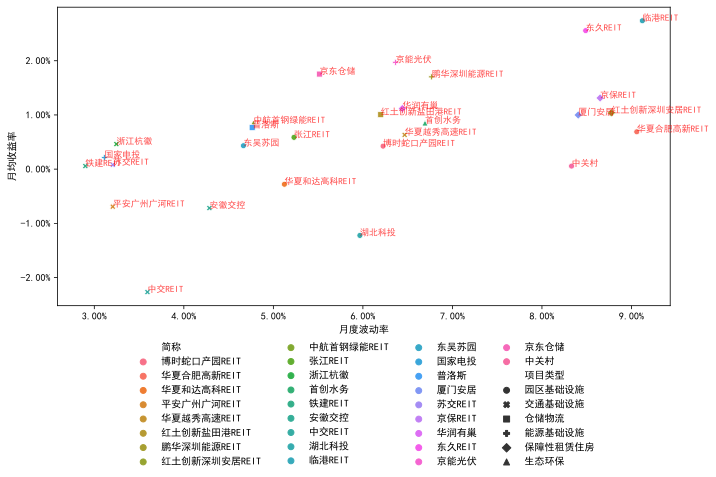

In [24]:
# REITs风险收益图(自己看的，标注版本)

# 读取生成的数据
df = pd.read_excel(path + '\\' + file,sheet_name="REITs风险收益")

# 将读取的第1列设置为索引，空白列名，默认值是'Unnamed: 0'
df.set_index('Unnamed: 0', inplace=True)
df.index.name=""  # 去掉'Unnamed: 0'

# 获取细分类别字段，并合并
df = pd.merge(
                        df,
                        # REITs属性(产权/经营权): fund_reitsrproperty；REITs细分板块(项目类型)：FUND__REITSTYPE
                        w.wss(df.index.to_list(), "fund_reitsrproperty, fund__reitstype", 
                              usedf=True)[1].rename(columns={"fund__reitstype".upper(): "项目类型"}), # 顺便重名列名，方便后面
                        left_index=True,right_index=True

                    )

df


# 画图
plt.figure(figsize=(11, 5.5))

# 这里画图的代码可以进一步参考：REITs_chart_v20230204.ipynb
# 案例一：sns画类别散点气泡图：
# http://seaborn.pydata.org/generated/seaborn.scatterplot.html
# https://blog.csdn.net/qq_45913057/article/details/123366205
# 优点：方便简洁：legend清晰
# sns.scatterplot(data=df, x='月度波动率',y='月均收益率', style="项目类型")
sns.scatterplot(data=df, x='月度波动率',y='月均收益率', hue="简称", style="项目类型")

# 百分比格式
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 


# 文本
# 给散点加标签
# texts = [plt.gca().text(df['月度波动率'].iloc[i], df['月均收益率'].iloc[i], df['简称'].iloc[i]) for i in range(len(df))]
texts = [plt.gca().text(df['月度波动率'].iloc[i], df['月均收益率'].iloc[i], df['简称'].iloc[i],
                        fontsize=9, color='red', alpha=0.7) for i in range(len(df))]


# 设置legend在图像外：http://www.kaotop.com/it/19432.html
plt.legend(bbox_to_anchor=(0.5, -0.55), loc=8, borderaxespad=0,fontsize=10, ncol=4, frameon=False) # legend在图外正下方
# 隐藏图例
# plt.gca().get_legend().remove()


plt.show()
